<a href="https://colab.research.google.com/github/prakharsinha/movie-recommendation-system/blob/master/movie-recommendation-system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- This notebook implements a movie recommender system. 
- Recommender systems are used to suggest movies or songs to users based on their interest or usage history. 
- For example, Netflix recommends movies to watch based on the previous movies you've watched.  
- In this example, we will use Item-based Collaborative Filter 



- Dataset MovieLens: https://grouplens.org/datasets/movielens/100k/ 


# STEP #0: LIBRARIES IMPORT


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## **The below Code Snippet is used to set connection between Google drive and Google Colab to load multiple files (Optional)**

In [2]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse



# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()


# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


# Create a directory and mount Google Drive using that directory.
!mkdir -p My Drive
!google-drive-ocamlfuse My Drive


!ls My Drive/

# Create a file in Drive.
!echo "This newly created file will appear in your Drive file list." > My Drive/created.txt

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131183 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.11-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.11-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.11-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

# STEP #1: IMPORT DATASET

In [3]:
# Two datasets are available, let's load the first one:
movie_titles_df = pd.read_csv("Drive/Movie-Recommendation-System/Dataset/Movie_Id_Titles")
movie_titles_df.head(20)

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)
5,6,Shanghai Triad (Yao a yao yao dao waipo qiao) ...
6,7,Twelve Monkeys (1995)
7,8,Babe (1995)
8,9,Dead Man Walking (1995)
9,10,Richard III (1995)


In [0]:
# Let's load the second one!
movies_rating_df = pd.read_csv('Drive/Movie-Recommendation-System/Dataset/u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])

In [5]:
movies_rating_df.head(10)

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
5,298,474,4,884182806
6,115,265,2,881171488
7,253,465,5,891628467
8,305,451,3,886324817
9,6,86,3,883603013


In [6]:
movies_rating_df.tail()

,user_id,item_id,rating,timestamp
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156
99999,12,203,3,879959583


In [0]:
# Let's drop the timestamp 
movies_rating_df.drop(['timestamp'], axis = 1, inplace = True)

In [8]:
movies_rating_df

,user_id,item_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1
5,298,474,4
6,115,265,2
7,253,465,5
8,305,451,3
9,6,86,3


In [9]:
movies_rating_df.describe()

,user_id,item_id,rating
count,100000.00000,100000.000000,100000.000000
mean,462.48475,425.530130,3.529860
std,266.61442,330.798356,1.125674
min,1.00000,1.000000,1.000000
25%,254.00000,175.000000,3.000000
50%,447.00000,322.000000,4.000000
75%,682.00000,631.000000,4.000000
max,943.00000,1682.000000,5.000000


In [10]:
movies_rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
user_id    100000 non-null int64
item_id    100000 non-null int64
rating     100000 non-null int64
dtypes: int64(3)
memory usage: 2.3 MB


In [0]:
# Let's merge both dataframes together so we can have ID with the movie name
movies_rating_df = pd.merge(movies_rating_df, movie_titles_df, on = 'item_id') 

In [12]:
movies_rating_df

,user_id,item_id,rating,title
0,196,242,3,Kolya (1996)
1,63,242,3,Kolya (1996)
2,226,242,5,Kolya (1996)
3,154,242,3,Kolya (1996)
4,306,242,5,Kolya (1996)
5,296,242,4,Kolya (1996)
6,34,242,5,Kolya (1996)
7,271,242,4,Kolya (1996)
8,201,242,4,Kolya (1996)
9,209,242,4,Kolya (1996)


In [13]:
movies_rating_df.shape

(100000, 4)

# STEP #2: VISUALIZE DATASET

In [14]:
movies_rating_df.groupby('title')['rating'].describe()

,count,mean,std,min,25%,50%,75%,max
title,,,,,,,,
'Til There Was You (1997),9.0,2.333333,1.000000,1.0,2.00,2.0,3.00,4.0
1-900 (1994),5.0,2.600000,1.516575,1.0,1.00,3.0,4.00,4.0
101 Dalmatians (1996),109.0,2.908257,1.076184,1.0,2.00,3.0,4.00,5.0
12 Angry Men (1957),125.0,4.344000,0.719588,2.0,4.00,4.0,5.00,5.0
187 (1997),41.0,3.024390,1.172344,1.0,2.00,3.0,4.00,5.0
2 Days in the Valley (1996),93.0,3.225806,0.957000,1.0,3.00,3.0,4.00,5.0
"20,000 Leagues Under the Sea (1954)",72.0,3.500000,0.731581,2.0,3.00,4.0,4.00,5.0
2001: A Space Odyssey (1968),259.0,3.969112,1.026307,1.0,3.00,4.0,5.00,5.0
3 Ninjas: High Noon At Mega Mountain (1998),5.0,1.000000,0.000000,1.0,1.00,1.0,1.00,1.0


In [0]:
ratings_df_mean = movies_rating_df.groupby('title')['rating'].describe()['mean']

In [0]:
ratings_df_count = movies_rating_df.groupby('title')['rating'].describe()['count']

In [17]:
ratings_df_count

title
'Til There Was You (1997)                                     9.0
1-900 (1994)                                                  5.0
101 Dalmatians (1996)                                       109.0
12 Angry Men (1957)                                         125.0
187 (1997)                                                   41.0
2 Days in the Valley (1996)                                  93.0
20,000 Leagues Under the Sea (1954)                          72.0
2001: A Space Odyssey (1968)                                259.0
3 Ninjas: High Noon At Mega Mountain (1998)                   5.0
39 Steps, The (1935)                                         59.0
8 1/2 (1963)                                                 38.0
8 Heads in a Duffel Bag (1997)                                4.0
8 Seconds (1994)                                              4.0
A Chef in Love (1996)                                         8.0
Above the Rim (1994)                                          5.0
Abso

In [0]:
ratings_mean_count_df = pd.concat([ratings_df_count, ratings_df_mean], axis = 1)

In [19]:
ratings_mean_count_df.reset_index()

,title,count,mean
0,'Til There Was You (1997),9.0,2.333333
1,1-900 (1994),5.0,2.600000
2,101 Dalmatians (1996),109.0,2.908257
3,12 Angry Men (1957),125.0,4.344000
4,187 (1997),41.0,3.024390
5,2 Days in the Valley (1996),93.0,3.225806
6,"20,000 Leagues Under the Sea (1954)",72.0,3.500000
7,2001: A Space Odyssey (1968),259.0,3.969112
8,3 Ninjas: High Noon At Mega Mountain (1998),5.0,1.000000
9,"39 Steps, The (1935)",59.0,4.050847


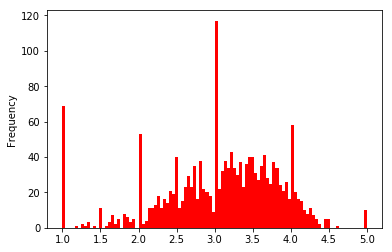

In [20]:
ratings_mean_count_df['mean'].plot(bins=100, kind='hist', color = 'r') 

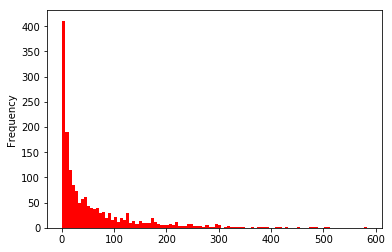

In [21]:
ratings_mean_count_df['count'].plot(bins=100, kind='hist', color = 'r') 

In [22]:
# Let's see the highest rated movies!
# Apparently these movies does not have many reviews (i.e.: small number of ratings)
ratings_mean_count_df[ratings_mean_count_df['mean'] == 5]

,count,mean
title,,
Aiqing wansui (1994),1.0,5.0
Entertaining Angels: The Dorothy Day Story (1996),1.0,5.0
"Great Day in Harlem, A (1994)",1.0,5.0
Marlene Dietrich: Shadow and Light (1996),1.0,5.0
Prefontaine (1997),3.0,5.0
"Saint of Fort Washington, The (1993)",2.0,5.0
Santa with Muscles (1996),2.0,5.0
Someone Else's America (1995),1.0,5.0
Star Kid (1997),3.0,5.0


In [23]:
# List all the movies that are most rated
# Please note that they are not necessarily have the highest rating (mean)
ratings_mean_count_df.sort_values('count', ascending = False).head(100)

,count,mean
title,,
Star Wars (1977),583.0,4.358491
Contact (1997),509.0,3.803536
Fargo (1996),508.0,4.155512
Return of the Jedi (1983),507.0,4.007890
Liar Liar (1997),485.0,3.156701
"English Patient, The (1996)",481.0,3.656965
Scream (1996),478.0,3.441423
Toy Story (1995),452.0,3.878319
Air Force One (1997),431.0,3.631090


# STEP #3: PERFORM ITEM-BASED COLLABORATIVE FILTERING ON ONE MOVIE SAMPLE

In [0]:
userid_movietitle_matrix = movies_rating_df.pivot_table(index = 'user_id', columns = 'title', values = 'rating')


In [25]:
userid_movietitle_matrix

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",8 1/2 (1963),8 Heads in a Duffel Bag (1997),8 Seconds (1994),A Chef in Love (1996),Above the Rim (1994),Absolute Power (1997),"Abyss, The (1989)",Ace Ventura: Pet Detective (1994),Ace Ventura: When Nature Calls (1995),Across the Sea of Time (1995),Addams Family Values (1993),Addicted to Love (1997),"Addiction, The (1995)","Adventures of Pinocchio, The (1996)","Adventures of Priscilla, Queen of the Desert, The (1994)","Adventures of Robin Hood, The (1938)","Affair to Remember, An (1957)","African Queen, The (1951)",Afterglow (1997),"Age of Innocence, The (1993)",Aiqing wansui (1994),Air Bud (1997),Air Force One (1997),"Air Up There, The (1994)",Airheads (1994),Akira (1988),Aladdin (1992),Aladdin and the King of Thieves (1996),Alaska (1996),Albino Alligator (1996),...,"Whole Wide World, The (1996)",Widows' Peak (1994),"Wife, The (1995)",Wild America (1997),Wild Bill (1995),"Wild Bunch, The (1969)",Wild Reeds (1994),Wild Things (1998),William Shakespeare's Romeo and Juliet (1996),Willy Wonka and the Chocolate Factory (1971),Window to Paris (1994),Wings of Courage (1995),Wings of Desire (1987),"Wings of the Dove, The (1997)",Winnie the Pooh and the Blustery Day (1968),"Winter Guest, The (1997)",Wishmaster (1997),With Honors (1994),Withnail and I (1987),Witness (1985),"Wizard of Oz, The (1939)",Wolf (1994),"Woman in Question, The (1950)","Women, The (1939)","Wonderful, Horrible Life of Leni Riefenstahl, The (1993)",Wonderland (1997),"Wooden Man's Bride, The (Wu Kui) (1994)","World of Apu, The (Apur Sansar) (1959)","Wrong Trousers, The (1993)",Wyatt Earp (1994),Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,4.0,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,2.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.0,NaN
6,NaN,NaN,NaN,4.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3

In [0]:
titanic = userid_movietitle_matrix['Titanic (1997)']


In [27]:
titanic

user_id
1      NaN
2      5.0
3      NaN
4      NaN
5      NaN
6      NaN
7      NaN
8      NaN
9      NaN
10     NaN
11     NaN
12     NaN
13     4.0
14     2.0
15     NaN
16     NaN
17     NaN
18     NaN
19     2.0
20     NaN
21     NaN
22     NaN
23     NaN
24     NaN
25     NaN
26     5.0
27     NaN
28     NaN
29     NaN
30     5.0
      ... 
914    3.0
915    4.0
916    NaN
917    NaN
918    NaN
919    5.0
920    5.0
921    5.0
922    NaN
923    NaN
924    4.0
925    NaN
926    3.0
927    NaN
928    NaN
929    NaN
930    NaN
931    4.0
932    NaN
933    NaN
934    3.0
935    5.0
936    4.0
937    NaN
938    5.0
939    NaN
940    5.0
941    NaN
942    3.0
943    NaN
Name: Titanic (1997), Length: 943, dtype: float64

In [28]:
# Let's calculate the correlations
titanic_correlations = pd.DataFrame(userid_movietitle_matrix.corrwith(titanic), columns=['Correlation'])
titanic_correlations = titanic_correlations.join(ratings_mean_count_df['count'])


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


In [29]:
titanic_correlations

,Correlation,count
title,,
'Til There Was You (1997),-0.062017,9.0
1-900 (1994),NaN,5.0
101 Dalmatians (1996),0.120113,109.0
12 Angry Men (1957),0.077700,125.0
187 (1997),0.315654,41.0
2 Days in the Valley (1996),0.017295,93.0
"20,000 Leagues Under the Sea (1954)",0.246718,72.0
2001: A Space Odyssey (1968),-0.042024,259.0
3 Ninjas: High Noon At Mega Mountain (1998),NaN,5.0


In [30]:
titanic_correlations.dropna(inplace=True)
titanic_correlations

,Correlation,count
title,,
'Til There Was You (1997),-0.062017,9.0
101 Dalmatians (1996),0.120113,109.0
12 Angry Men (1957),0.077700,125.0
187 (1997),0.315654,41.0
2 Days in the Valley (1996),0.017295,93.0
"20,000 Leagues Under the Sea (1954)",0.246718,72.0
2001: A Space Odyssey (1968),-0.042024,259.0
"39 Steps, The (1935)",0.155752,59.0
8 1/2 (1963),-0.039301,38.0


In [31]:
# Let's sort the correlations vector
titanic_correlations.sort_values('Correlation', ascending=False)

,Correlation,count
title,,
Nadja (1994),1.0,8.0
"Pest, The (1997)",1.0,8.0
"Savage Nights (Nuits fauves, Les) (1992)",1.0,3.0
For Ever Mozart (1996),1.0,3.0
"Jerky Boys, The (1994)",1.0,3.0
"Newton Boys, The (1998)",1.0,4.0
Hearts and Minds (1996),1.0,5.0
"Simple Wish, A (1997)",1.0,3.0
Purple Noon (1960),1.0,7.0


In [32]:
titanic_correlations[titanic_correlations['count']>80].sort_values('Correlation',ascending=False).head()

,Correlation,count
title,,
Titanic (1997),1.000000,350.0
"River Wild, The (1994)",0.497600,146.0
"Abyss, The (1989)",0.472103,151.0
Bram Stoker's Dracula (1992),0.443560,120.0
True Lies (1994),0.435104,208.0


# STEP#4: CREATE AN ITEM-BASED COLLABORATIVE FILTER ON THE ENTIRE DATASET 

In [33]:
# Recall this matrix that we created earlier of all movies and their user ID/ratings
userid_movietitle_matrix

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",8 1/2 (1963),8 Heads in a Duffel Bag (1997),8 Seconds (1994),A Chef in Love (1996),Above the Rim (1994),Absolute Power (1997),"Abyss, The (1989)",Ace Ventura: Pet Detective (1994),Ace Ventura: When Nature Calls (1995),Across the Sea of Time (1995),Addams Family Values (1993),Addicted to Love (1997),"Addiction, The (1995)","Adventures of Pinocchio, The (1996)","Adventures of Priscilla, Queen of the Desert, The (1994)","Adventures of Robin Hood, The (1938)","Affair to Remember, An (1957)","African Queen, The (1951)",Afterglow (1997),"Age of Innocence, The (1993)",Aiqing wansui (1994),Air Bud (1997),Air Force One (1997),"Air Up There, The (1994)",Airheads (1994),Akira (1988),Aladdin (1992),Aladdin and the King of Thieves (1996),Alaska (1996),Albino Alligator (1996),...,"Whole Wide World, The (1996)",Widows' Peak (1994),"Wife, The (1995)",Wild America (1997),Wild Bill (1995),"Wild Bunch, The (1969)",Wild Reeds (1994),Wild Things (1998),William Shakespeare's Romeo and Juliet (1996),Willy Wonka and the Chocolate Factory (1971),Window to Paris (1994),Wings of Courage (1995),Wings of Desire (1987),"Wings of the Dove, The (1997)",Winnie the Pooh and the Blustery Day (1968),"Winter Guest, The (1997)",Wishmaster (1997),With Honors (1994),Withnail and I (1987),Witness (1985),"Wizard of Oz, The (1939)",Wolf (1994),"Woman in Question, The (1950)","Women, The (1939)","Wonderful, Horrible Life of Leni Riefenstahl, The (1993)",Wonderland (1997),"Wooden Man's Bride, The (Wu Kui) (1994)","World of Apu, The (Apur Sansar) (1959)","Wrong Trousers, The (1993)",Wyatt Earp (1994),Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,4.0,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,2.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.0,NaN
6,NaN,NaN,NaN,4.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3

In [0]:
movie_correlations = userid_movietitle_matrix.corr(method = 'pearson', min_periods = 80)
# pearson : standard correlation coefficient
# Obtain the correlations between all movies in the dataframe

In [35]:
movie_correlations

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",8 1/2 (1963),8 Heads in a Duffel Bag (1997),8 Seconds (1994),A Chef in Love (1996),Above the Rim (1994),Absolute Power (1997),"Abyss, The (1989)",Ace Ventura: Pet Detective (1994),Ace Ventura: When Nature Calls (1995),Across the Sea of Time (1995),Addams Family Values (1993),Addicted to Love (1997),"Addiction, The (1995)","Adventures of Pinocchio, The (1996)","Adventures of Priscilla, Queen of the Desert, The (1994)","Adventures of Robin Hood, The (1938)","Affair to Remember, An (1957)","African Queen, The (1951)",Afterglow (1997),"Age of Innocence, The (1993)",Aiqing wansui (1994),Air Bud (1997),Air Force One (1997),"Air Up There, The (1994)",Airheads (1994),Akira (1988),Aladdin (1992),Aladdin and the King of Thieves (1996),Alaska (1996),Albino Alligator (1996),...,"Whole Wide World, The (1996)",Widows' Peak (1994),"Wife, The (1995)",Wild America (1997),Wild Bill (1995),"Wild Bunch, The (1969)",Wild Reeds (1994),Wild Things (1998),William Shakespeare's Romeo and Juliet (1996),Willy Wonka and the Chocolate Factory (1971),Window to Paris (1994),Wings of Courage (1995),Wings of Desire (1987),"Wings of the Dove, The (1997)",Winnie the Pooh and the Blustery Day (1968),"Winter Guest, The (1997)",Wishmaster (1997),With Honors (1994),Withnail and I (1987),Witness (1985),"Wizard of Oz, The (1939)",Wolf (1994),"Woman in Question, The (1950)","Women, The (1939)","Wonderful, Horrible Life of Leni Riefenstahl, The (1993)",Wonderland (1997),"Wooden Man's Bride, The (Wu Kui) (1994)","World of Apu, The (Apur Sansar) (1959)","Wrong Trousers, The (1993)",Wyatt Earp (1994),Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
'Til There Was You (1997),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1-900 (1994),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101 Dalmatians (1996),NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.105261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12 Angry Men (1957),NaN,NaN,NaN,1.000000,NaN,NaN,NaN,0.178848,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187 (1997),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2 Days in the Valley (1996),NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [36]:
# Let's create our own dataframe with our own ratings!
myRatings = pd.read_csv("Drive/Project 8/My_Ratings.csv")
#myRatings.reset_index

FileNotFoundError: ignored

In [0]:
myRatings

In [0]:
len(myRatings.index)

In [0]:
myRatings['Movie Name'][0]

In [0]:
similar_movies_list = pd.Series()
for i in range(0, 2):
    similar_movie = movie_correlations[myRatings['Movie Name'][i]].dropna() # Get same movies with same ratings
    similar_movie = similar_movie.map(lambda x: x * myRatings['Ratings'][i]) # Scale the similarity by your given ratings
    similar_movies_list = similar_movies_list.append(similar_movie)


In [0]:
similar_movies_list.sort_values(inplace = True, ascending = False)
print (similar_movies_list.head(10))